Some initial imports, do **NOT** write any new code here:

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt


from datasets import load_dataset
from huggingface_hub import hf_hub_download

# Question 1: MRI Modality Translation (T1 → T2)

Magnetic Resonance Imaging (MRI) is a key modality for brain and brain tumour assessment. Different MRI contrasts highlight different tissue properties: for example, T1-weighted images provide good anatomical detail, while T2-weighted images are more sensitive to fluid and oedema, and often make tumour-related abnormalities more conspicuous. In clinical practice, not all contrasts are always acquired for every patient or every time point, and multi-contrast data can be incomplete or heterogeneous. Learning mappings between MRI modalities is therefore relevant for tasks such as image completion, protocol harmonisation, and data augmentation.

In this question you will work with a pre-processed dataset derived from a public brain tumour MRI collection. For each patient, paired **T1** and **T2** images have been extracted as **2D slices** from 3D volumes in several canonical views (axial, sagittal, coronal). The data have been co-registered, skull-stripped, and resampled to **single-channel 64×64** slices and split into **training** and **validation** sets. Each example includes:
- `patient_id`: an anonymised identifier for the patient  
- `split`: the dataset split (`train` or `validation`)  
- `view`: the anatomical view (`axial`, `sagittal`, or `coronal`)  
- `t1`: a 2D T1-weighted slice (shape `(1, 64, 64)`)  
- `t2`: the corresponding T2-weighted slice (same shape as `t1`)

Throughout this question, you will treat **T1 slices as inputs** and **T2 slices as targets** in an image-to-image regression setting.

This question is divided into three parts:

- **Part 1.A – Exploratory Data Analysis and Pre-processing**: you will inspect the dataset, develop simple visualisations, and design a basic intensity normalisation pipeline.  
- **Part 1.B – Modality Translation Model**: you will build and train a deep learning model that maps T1 slices to T2 slices, and evaluate its performance quantitatively and qualitatively.  
- **Part 1.C – Discussion**: you will critically reflect on your modelling choices, results, and limitations in a concise written analysis.

<br>

---

<br>

The next few blocks of code provided in the notebook will download and load the dataset from the Hugging Face Hub, and show you basic usage of the `datasets` API for accessing slices and metadata.


In [4]:
train_dataset = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="train")
valid_dataset = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="validation")

train_dataset, valid_dataset

README.md:   0%|          | 0.00/711 [00:00<?, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/232M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

data/validation-00000-of-00002.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

data/validation-00001-of-00002.parquet:   0%|          | 0.00/183M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/116235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/39375 [00:00<?, ? examples/s]

(Dataset({
     features: ['patient_id', 'split', 'view', 't1', 't2'],
     num_rows: 116235
 }),
 Dataset({
     features: ['patient_id', 'split', 'view', 't1', 't2'],
     num_rows: 39375
 }))

In [5]:
# Applying a transform to the dataset, this can also incluse torchvision transforms
def basic_transform_fn(sample_):
    if "t1" in sample_:
        sample_["t1"] = torch.tensor(sample_["t1"])
    if "t2" in sample_:
        sample_["t2"] = torch.tensor(sample_["t2"])
    return sample_

train_dataset = train_dataset.with_transform(basic_transform_fn)
valid_dataset = valid_dataset.with_transform(basic_transform_fn)

train_dataset[0]["t1"].shape, valid_dataset[0]["t1"].shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

<br><br>

## 1.A) Exploratory Data Analysis and Pre-processing

In this part you will carry out basic exploratory analysis of the paired T1/T2 slice dataset and design a simple pre-processing strategy that will be reused in Part 1.B.

Using the provided loading code and any helper functions you choose to implement, you should:

1. **Visualise representative T1–T2 pairs**  
   - For each anatomical view, plot a small grid of 8 T1/T2 pairs from the training set. Arrange the plots so that for each example the T1 input and its corresponding T2 target can be compared side-by-side (or in successive rows), and ensure that axes and titles are clearly labelled.

2. **Analyse intensity distributions**  
   - Plot histograms (or density plots) of pixel intensities for T1 and T2 slices, separately for the training and validation sets.  

3. **Design a simple intensity pre-processing transform**  
   - Based on your histograms of (2), propose and implement a basic normalisation scheme for `t1` and `t2` that is suitable for the task you will be carrying out in Part 1.B. For instance, you might try scaling the pixels to a fixed range such as \([0,1]\) or \([-1,1]\)) if you feel that is appropriate.

   - Apply this transform to the dataset and re-plot a few T1/T2 pairs and intensity histograms to verify that the transformed images are numerically well-behaved while preserving relevant anatomical structure.  


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

In [6]:
# initialise seed to manage reproducibility
import random

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

set_seed(42)

True

1. **Visualise representative T1–T2 pairs**

In [7]:
num_samples = 8 # initialise number of samples we want for each view

# initialise counters and sample lists for axial, sagittal, and coronal

axial_counter = 0
axial_samples = []

sagittal_counter = 0
sagittal_samples = []

coronal_counter = 0
coronal_samples = []

# keep track of the sample indices to avoid sampling twice from the same one
indices_tracking = []

# while loop with break condition when all counters are equal to 8
while True:

  # randomly sample dataset index
  idx = torch.randint(0, len(train_dataset) - 1, (1,))

  if idx not in indices_tracking: # check if we already sampled from the index

    indices_tracking.append(idx) # append index to tracking list
    sample = train_dataset[idx.item()] # access sample from train_dataset

    # check for the sample view and for counter being lower than the number of
    # samples we want for each view. where conditions are met, increase
    # corresponding counter by 1 and append sample to corresponding list

    if sample["view"] == "axial" and axial_counter < num_samples:
      axial_counter += 1
      axial_samples.append(sample)

    elif sample["view"] == "sagittal" and sagittal_counter < num_samples:
      sagittal_counter += 1
      sagittal_samples.append(sample)

    elif sample["view"] == "coronal" and coronal_counter < num_samples:
      coronal_counter += 1
      coronal_samples.append(sample)

    # boolean for 3 conditions to be met
    cond_1 = (axial_counter == num_samples)
    cond_2 = (sagittal_counter == num_samples)
    cond_3 = (coronal_counter == num_samples)

    # break if all 3 conditions are met
    if cond_1 and cond_2 and cond_3:
      break

In [8]:
# helper function to plot samples by view
def plot_samples(samples, num_samples=8):
  # initialise sumples subplots: rows = number of samples, cols = 2 (T1 and T2)
  fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))

  for row_idx, sample in enumerate(samples):

    t1_img = sample["t1"].permute(1, 2, 0)
    t2_img = sample["t2"].permute(1, 2, 0)

    # left Column: T1 Input
    axes[row_idx, 0].imshow(t1_img, cmap="gray")
    axes[row_idx, 0].set_title(f"T1 Input (ID: {sample['patient_id']})")
    axes[row_idx, 0].set_ylabel(f"View: {sample['view']}")

    # right Column: T2 Target
    axes[row_idx, 1].imshow(t2_img, cmap="gray")
    axes[row_idx, 1].set_title(f"T2 Target (Split: {sample['split']})")

  plt.tight_layout()
  plt.show()

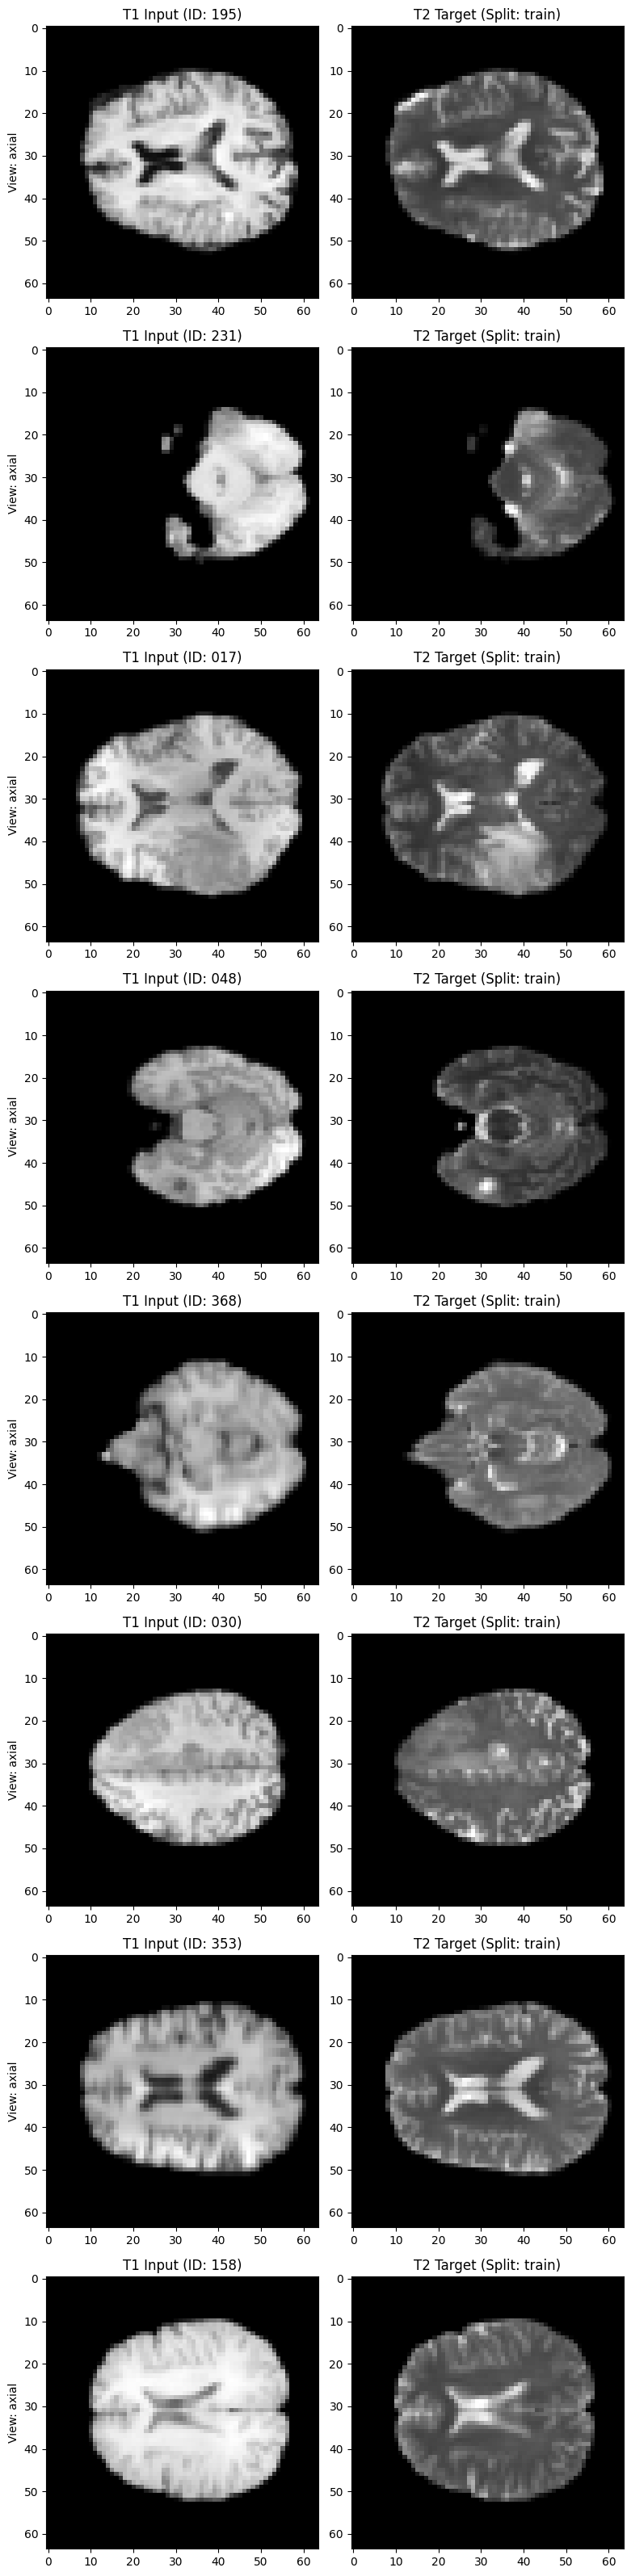

In [7]:
# axial view plotting
plot_samples(axial_samples)

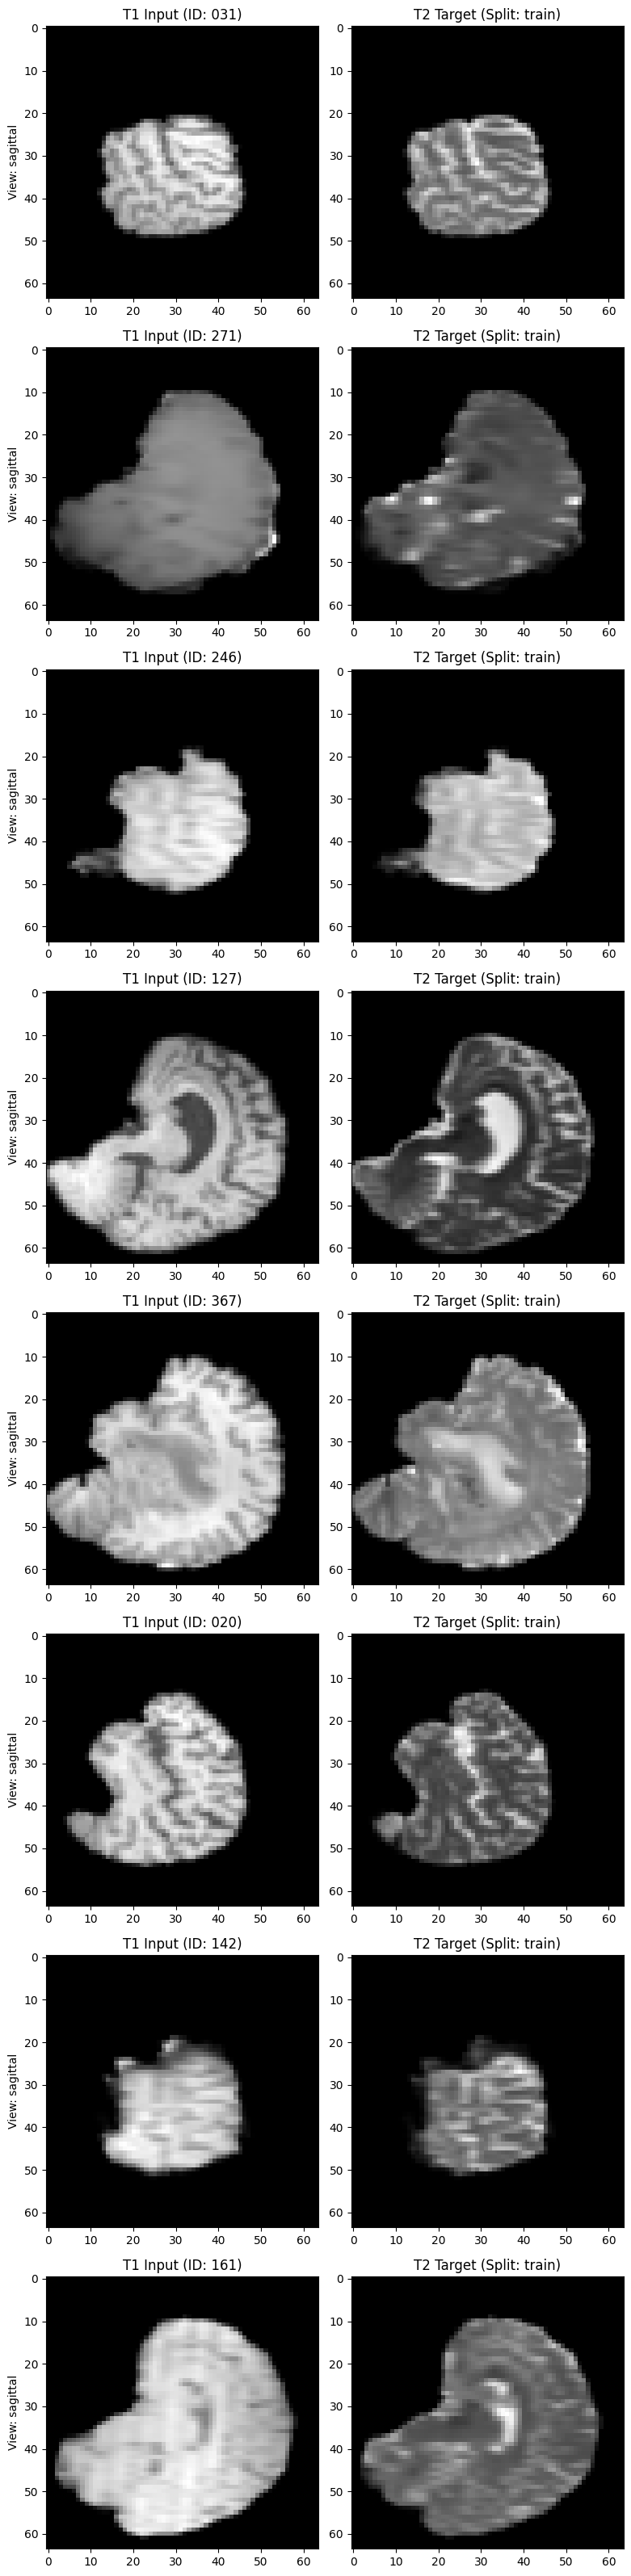

In [8]:
# sagittal view plotting
plot_samples(sagittal_samples)

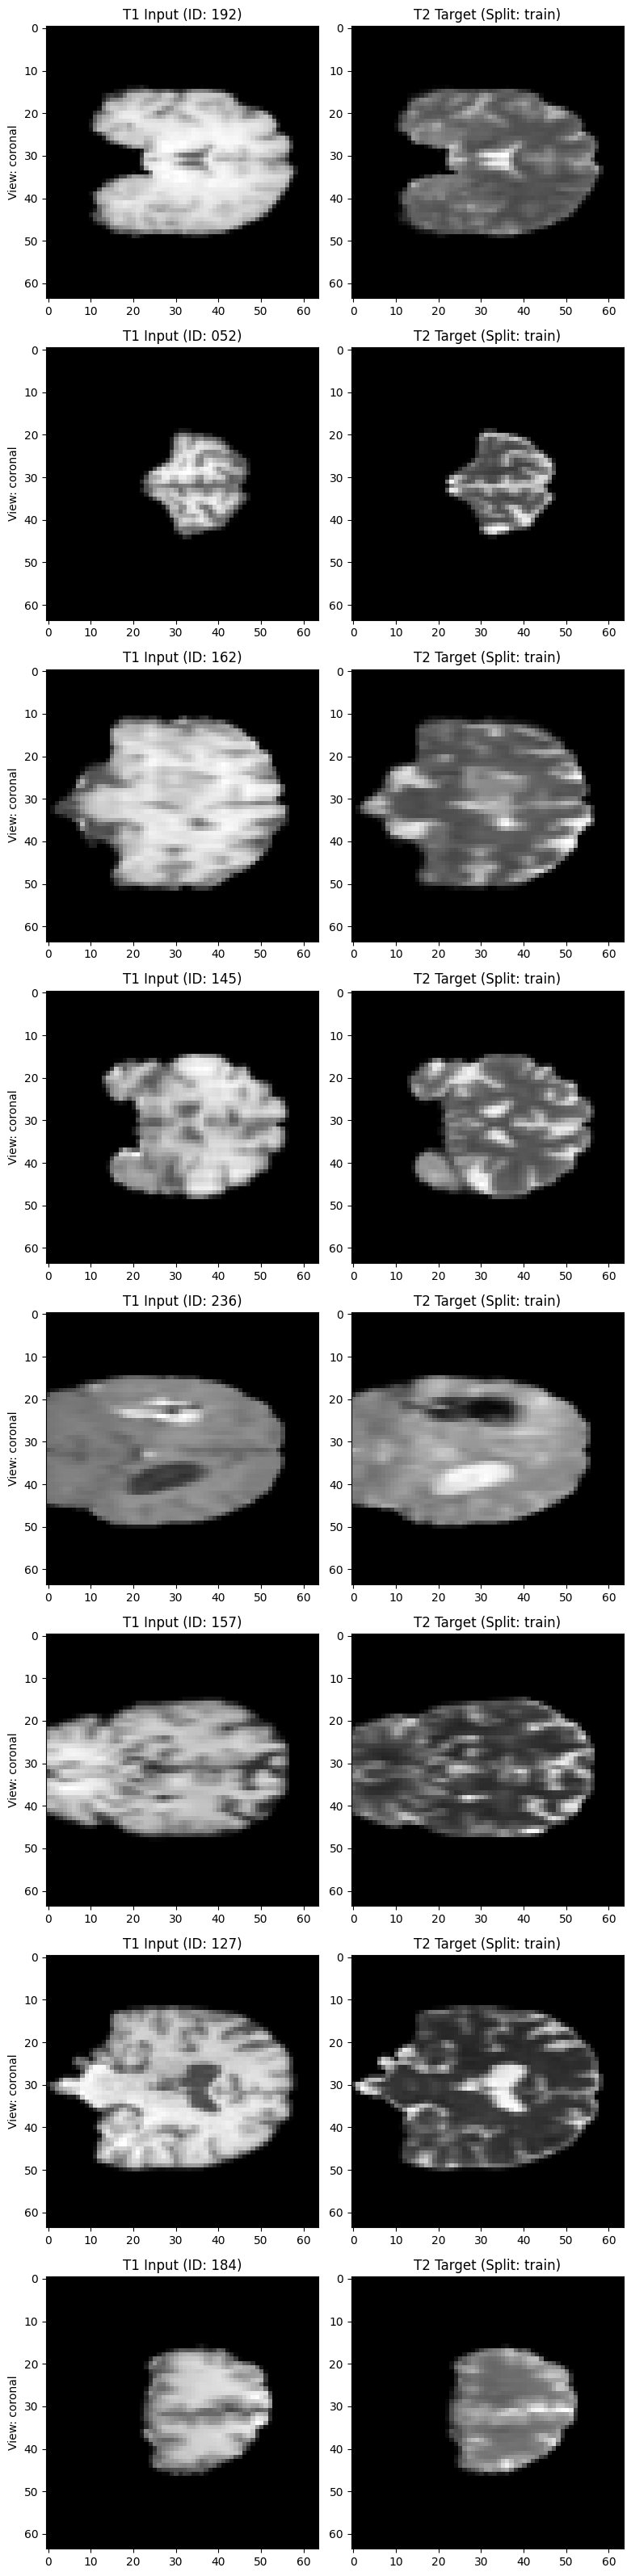

In [9]:
# coronal view plotting
plot_samples(coronal_samples)

<br>

2. **Analyse intensity distributions**  

In [9]:
# helper function to plot distributions and check for samples with extreme values
def plot_pixel_hist_sampled(dataset,
                            max_images=3000,     # limit sampled images
                            pixels_per_image=4096, # 64*64 pixels
                            bins=100,
                            plot_high_sample=False):

    n = len(dataset)
    # sample indices
    idxs = random.sample(range(n), min(max_images, n))

    t1_vals = []
    t2_vals = []

    sample_outlier = []
    outlier_count = 0

    for i in idxs:
        s = dataset[i]
        t1 = s["t1"].flatten()
        t2 = s["t2"].flatten()

        # subsample pixels from each image
        k = min(pixels_per_image, t1.numel())
        perm = torch.randperm(t1.numel())[:k] # shuffle in case pixels are more
        # append t1 and t2
        t1_vals.append(t1[perm])
        t2_vals.append(t2[perm])

        if np.array(t1_vals).max() > 25000 and np.array(t2_vals).max() > 25000:
          if outlier_count < 8:
            sample_outlier.append(s)
            outlier_count += 1

    # concat all values
    t1_all = torch.cat(t1_vals)
    t2_all = torch.cat(t2_vals)

    # filter out background 0 pixels
    t1_all = t1_all[t1_all > 0]
    t2_all = t2_all[t2_all > 0]

    print(f"T1 mean: {t1_all.numpy().mean()}, T1 median: {np.median(t1_all.numpy())}, T1 min: {t1_all.numpy().min()}, T1 max: {t1_all.numpy().max()}")
    print(f"T2 mean: {t2_all.numpy().mean()}, T2 median: {np.median(t2_all.numpy())}, T2 min: {t2_all.numpy().min()}, T2 max: {t2_all.numpy().max()}")

    # plot t1 and t2 distributions overlapped
    plt.figure(figsize=(10, 6))
    plt.hist(t1_all.numpy(), bins=bins, alpha=0.5, label='T1 Input', density=True)
    plt.hist(t2_all.numpy(), bins=bins, alpha=0.5, label='T2 Target', density=True)
    plt.title('Pixel Intensity Distribution: T1 vs T2 (sampled)')
    plt.xlabel('Intensity Value')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    if plot_high_sample == True:
      plot_samples(sample_outlier, num_samples=8)


T1 mean: 609.91015625, T1 median: 357.3999938964844, T1 min: 0.03999999910593033, T1 max: 25533.734375
T2 mean: 712.6018676757812, T2 median: 416.8666687011719, T2 min: 0.03999999910593033, T2 max: 31255.650390625


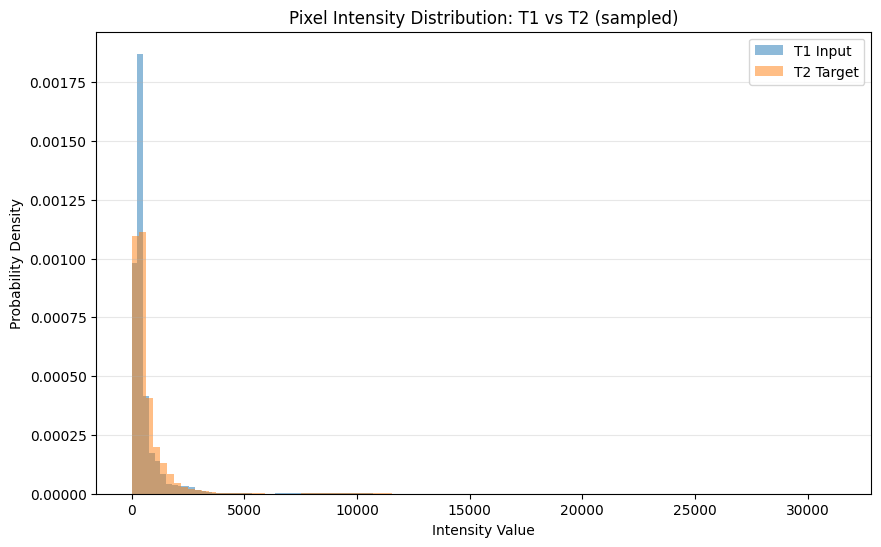

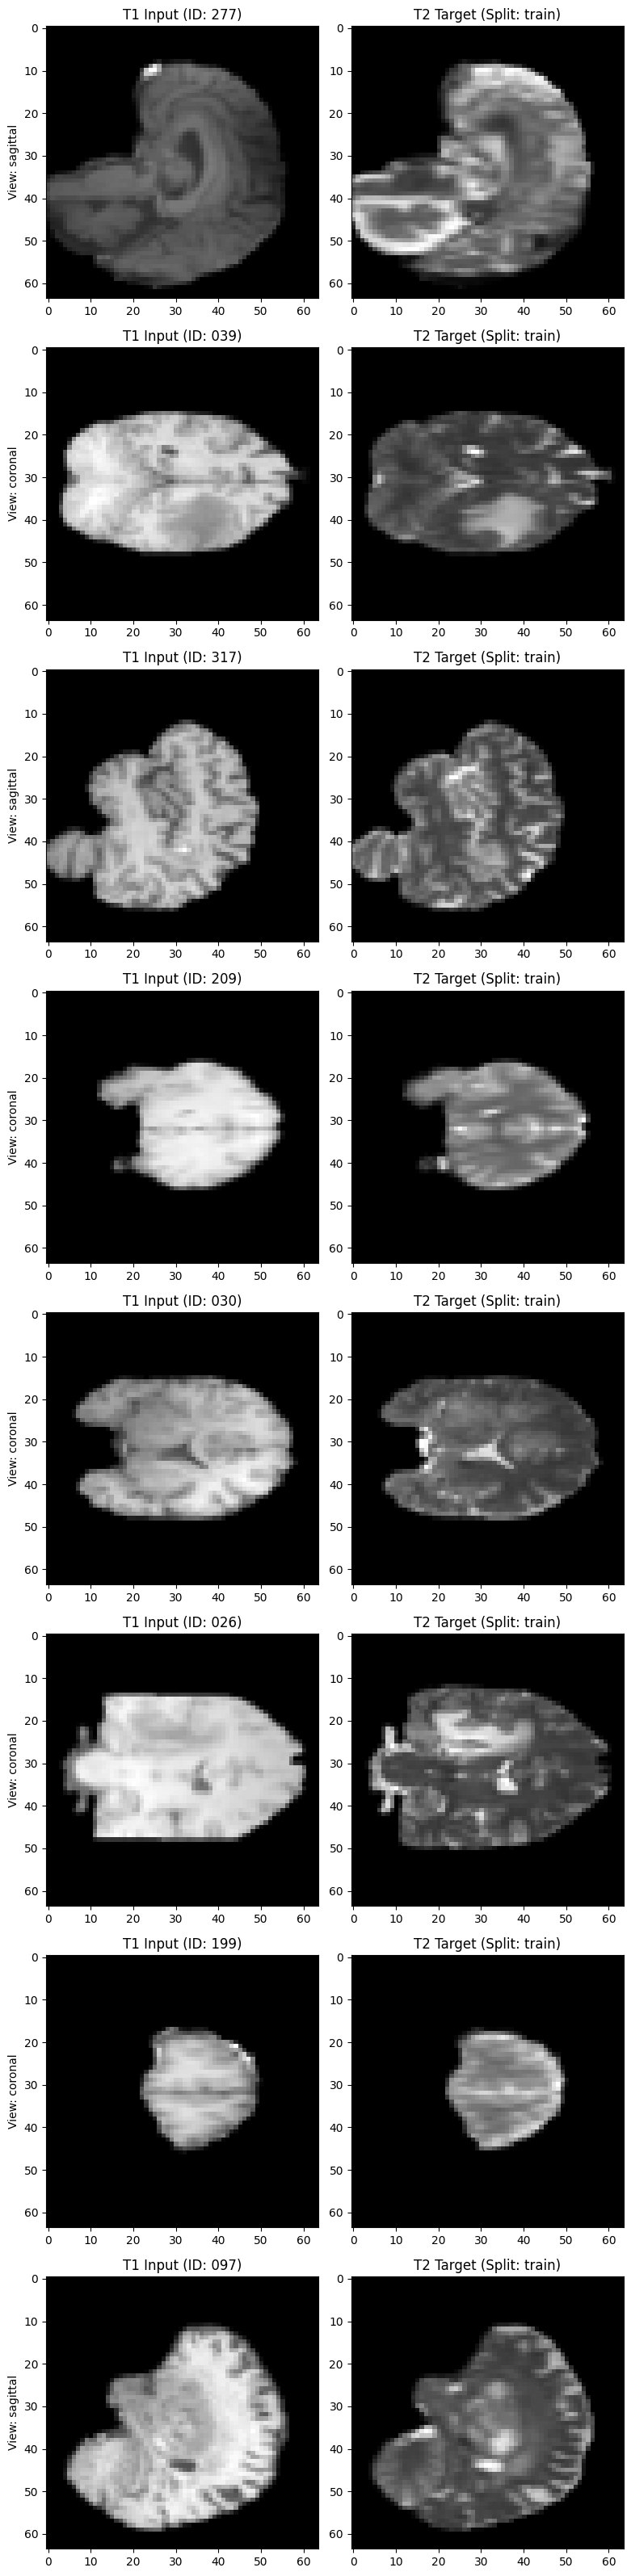

In [11]:
plot_pixel_hist_sampled(train_dataset, plot_high_sample=True)

T1 mean: 1446.417724609375, T1 median: 370.8125, T1 min: 0.0013946533435955644, T1 max: 26946.150390625
T2 mean: 1200.844482421875, T2 median: 462.8666687011719, T2 min: 0.03999999910593033, T2 max: 30630.083984375


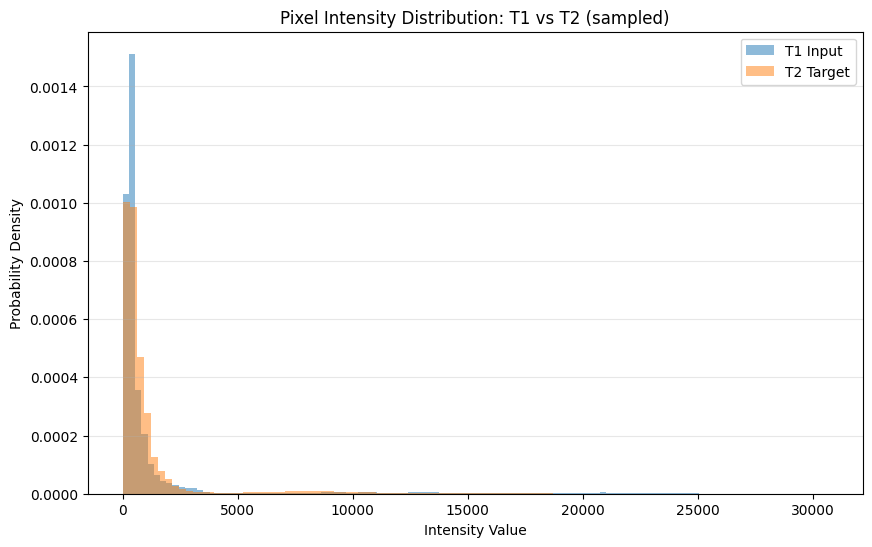

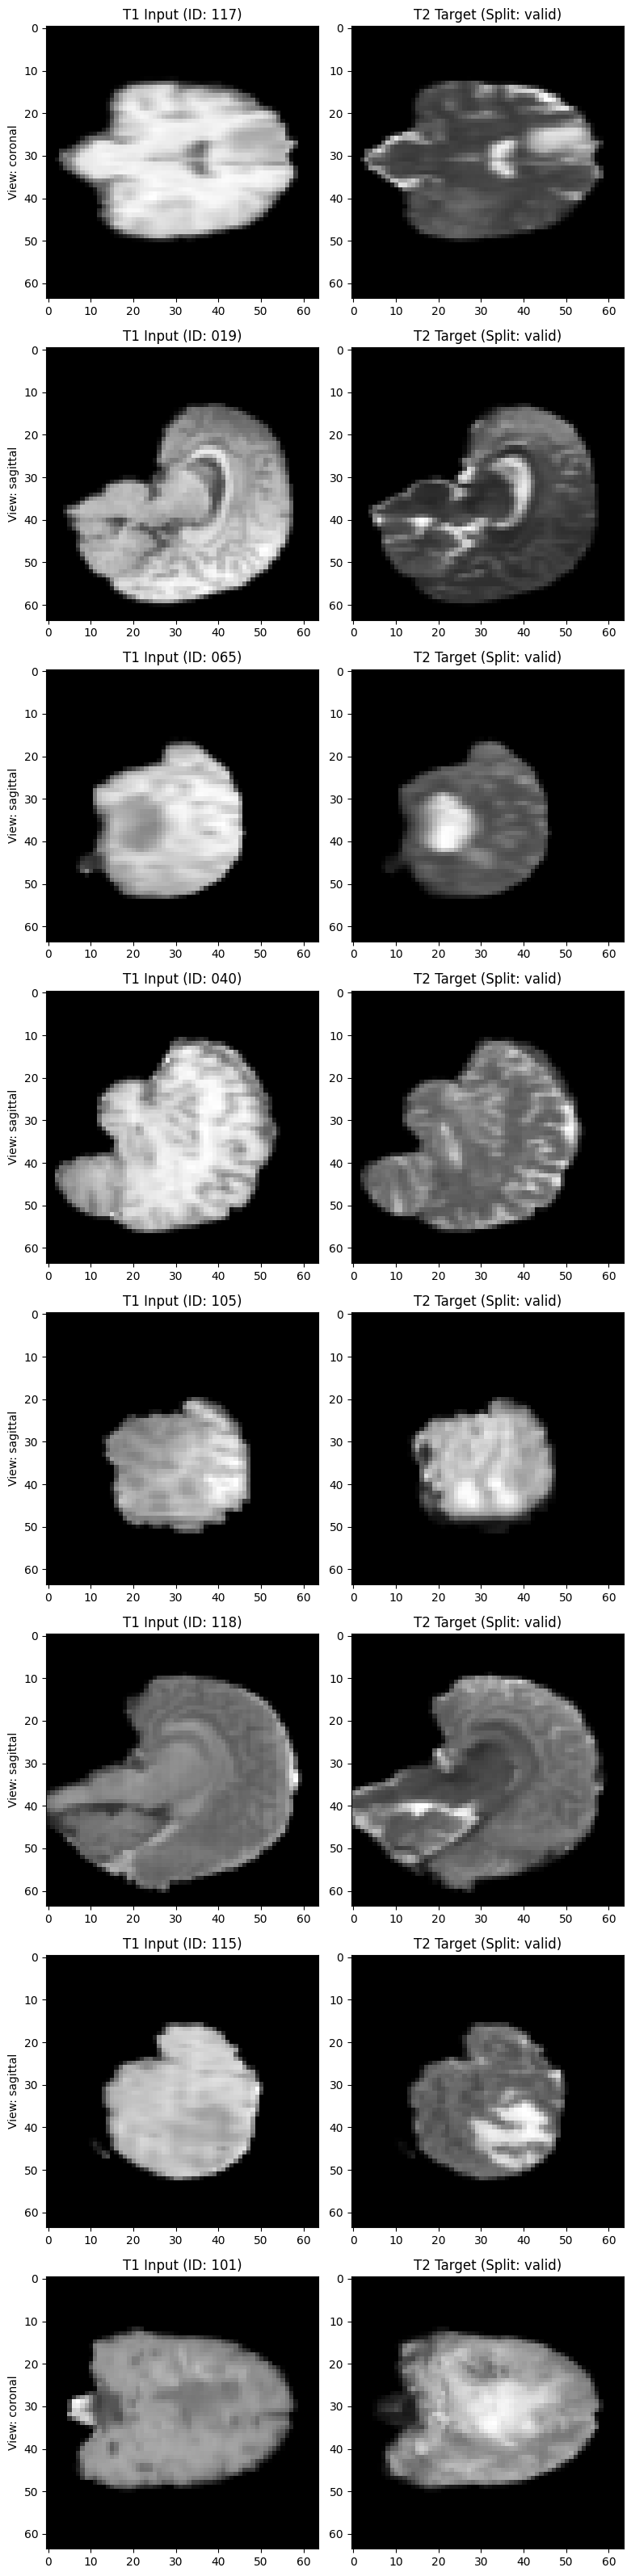

In [12]:
plot_pixel_hist_sampled(valid_dataset, plot_high_sample=True)

<br>

3. **Design a simple intensity pre-processing transform**

In [10]:
def minmax_transform_fn(sample_):
    def normalize(x):
        # convert to float tensor
        x = torch.tensor(x, dtype=torch.float32)

        # flatten for percentile computation
        flat = x.flatten()

        # compute 1% and 99% percentiles
        p1 = torch.quantile(flat, 0.01)
        p99 = torch.quantile(flat, 0.99)

        # clip between percentiles
        x = torch.clamp(x, p1, p99)

        # min-max normalise (safe since p99 > p1)
        x = (x - p1) / (p99 - p1)

        return x

    if "t1" in sample_:
        sample_["t1"] = normalize(sample_["t1"])

    if "t2" in sample_:
        sample_["t2"] = normalize(sample_["t2"])

    return sample_

In [11]:
train_dataset_norm = train_dataset.with_transform(minmax_transform_fn)
valid_dataset_norm = valid_dataset.with_transform(minmax_transform_fn)

train_loader = torch.utils.data.DataLoader(train_dataset_norm, shuffle=True, batch_size=64, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset_norm, shuffle=False, batch_size=64, num_workers=0)

In [15]:
from torchvision.utils import make_grid

def plot_batch(batch, nrow=8, title="", ax=None):
    """Plot a batch of images in a grid format."""
    ncol = batch.size(0) // nrow
    grid = make_grid(batch, nrow=nrow).permute(1, 2, 0)
    if ax is None:
        _, ax = plt.subplots(figsize=(2*nrow, 2*ncol))
    ax.imshow(grid.cpu())
    ax.axis('off')
    if title:
        ax.set_title(title)
    if ax is None:
        plt.show()

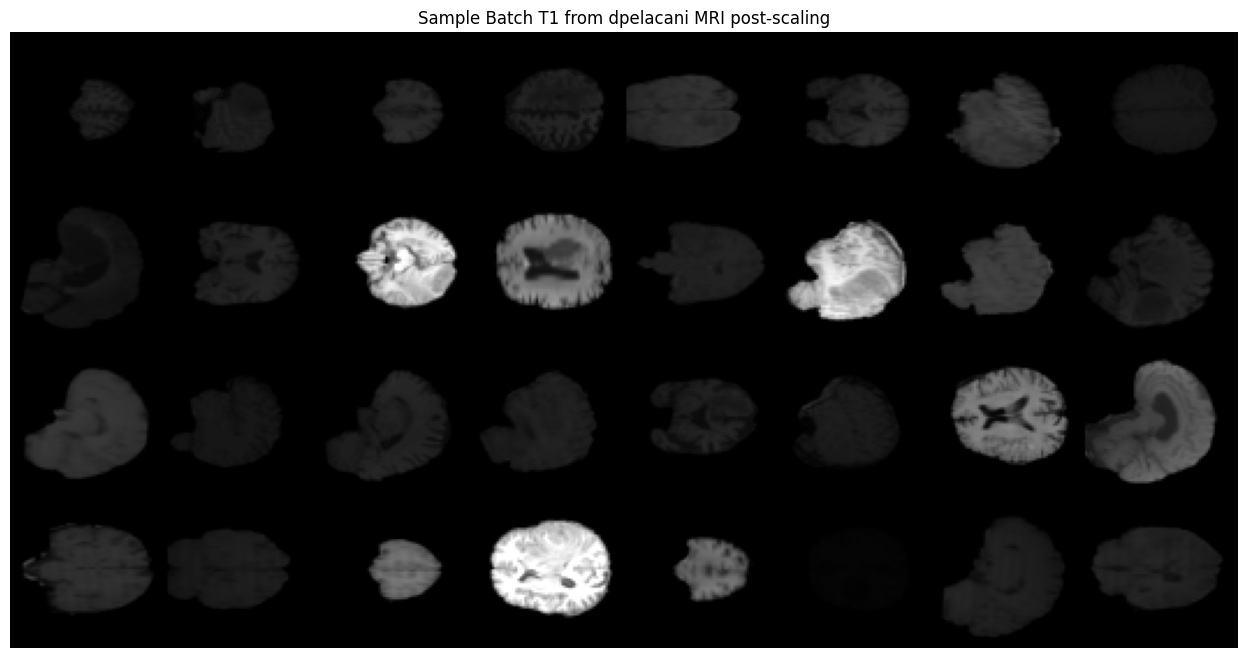

In [16]:
batch_t1 = next(iter(train_loader))["t1"][:32]
plot_batch(batch_t1, nrow=8, title="Sample Batch T1 from dpelacani MRI post-scaling")

In [17]:
batch_t1.min(), batch_t1.max()

(tensor(0.), tensor(1.))

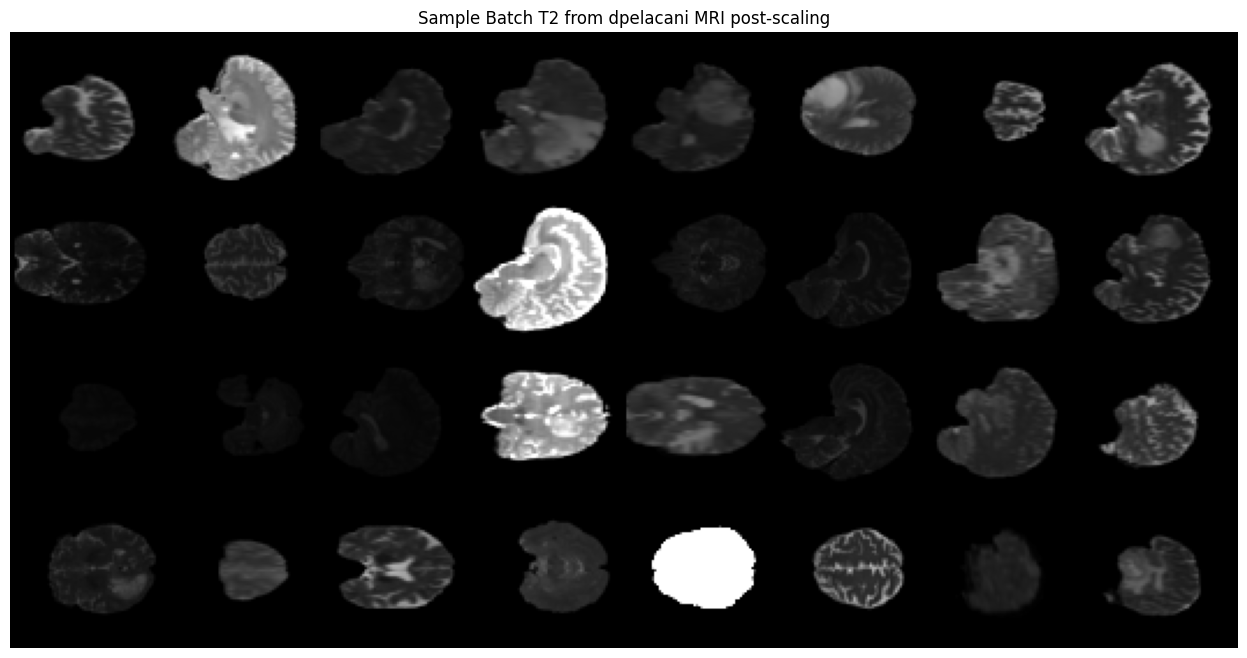

In [18]:
batch_t2 = next(iter(train_loader))["t2"][:32]
plot_batch(batch_t2, nrow=8, title="Sample Batch T2 from dpelacani MRI post-scaling")

In [19]:
batch_t2.min(), batch_t2.max()

(tensor(0.), tensor(1.))

<br><br>

## 1.B) Modality Translation (T1 → T2)

In this part you will build an **image-to-image model** that takes a T1-weighted slice as input and predicts the corresponding T2-weighted slice. Each training example is therefore a pair $(\text{T1}, \text{T2})$ with matching spatial dimensions.

You are free to design the model architecture, but it must satisfy the following requirements:

- It should operate on 2D slices and produce an output with the **same spatial resolution** as the input
- It should take `t1` as input and learn to approximate `t2` as output, using the pre-processed data from Part 1.A.  

In designing your solution, you must determine:

- a **suitable architecture**, keeping in mind that simpler models should remain functional and that more complex designs may yield improved performance;  
- the **loss function** and **optimisation setup** you believe appropriate for this task;  
- the **evaluation strategy**, including at least one quantitative metric and the qualitative visualisation of predicted T2 images.

Key points to consider:

- You are expected to design the full solution **yourself**: the model, the preprocessing pipeline, and the overall training procedure. You must also decide on **suitable evaluation metrics** for this problem. **Strong solutions will ensure that the model can both preserve image quality and generalise well to the validation set.**

- Only include code that is necessary to reproduce your results. Notebook organisation and clarity form part of the assessment (see the main *README*).

- You should ensure that the notebook clearly displays example outputs of your **final trained model on the validation set**, as well as at least one plot showing how your chosen **evaluation metric(s) evolve over training iterations or epochs.**

- You may include **up to two** solutions in this notebook, in recognition that partially working attempts may still receive marks under the criteria outlined in the *README*, but you are encouraged to start with a simple, reliable baseline before attempting a more complex model.


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

In [12]:
# mount drive to periodically save model during training
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Mounted at /content/drive


In [13]:
# check device

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [14]:
import torch.nn as nn

class PreFeatureExtractor(nn.Module):
    def __init__(self, in_channels=1, out_channels=6):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act  = nn.ReLU()

    def forward(self, x):
        return self.act(self.conv(x))

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate=16):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # x is the concatenated features so far
        return self.layer(x)   # returns ONLY the new 16 channels


class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate=16, num_layers=5):
        super().__init__()
        self.layers = nn.ModuleList()
        current_channels = in_channels

        for _ in range(num_layers):
            self.layers.append(DenseLayer(current_channels, growth_rate))
            current_channels += growth_rate   # input to next = prev + new 16

        self.out_channels = num_layers * growth_rate  # 5 * 16 = 80

    def forward(self, x):
        features = []
        concat_feats = x

        for layer in self.layers:
            new_feat = layer(concat_feats)              # [B, 16, H, W]
            features.append(new_feat)                   # store for final output
            concat_feats = torch.cat([concat_feats, new_feat], dim=1) # dense connectivity

        # block output: only the new features, 5 * 16 = 80 channels
        return torch.cat(features, dim=1)

pre = PreFeatureExtractor(in_channels=1, out_channels=6)
dense = DenseBlock(in_channels=6, growth_rate=16, num_layers=5)

x = torch.randn(1, 1, 64, 64)  # T1 only
f1 = pre(x)                    # [1, 6, 64, 64]
y  = dense(f1)                 # [1, 80, 64, 64]
print(f1.shape, y.shape)

torch.Size([1, 6, 64, 64]) torch.Size([1, 80, 64, 64])


In [15]:
class TranslationLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

translated = TranslationLayer(80, 64)(y)
print(translated.shape)         # shape: [B, 80, 64, 64]

torch.Size([1, 64, 64, 64])


In [16]:
class EncBlock(nn.Module):
    """Dense U-Net encoder block"""

    def __init__(self, in_c, pre_feat, growth_rate, num_layers, out_c):
        super().__init__()
        self.pre_feature = PreFeatureExtractor(in_c, pre_feat)
        self.dense_block = DenseBlock(pre_feat, growth_rate, num_layers)
        self.trans_layer = TranslationLayer(self.dense_block.out_channels, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        h = self.pre_feature(x)
        h = self.dense_block(h)
        h = self.trans_layer(h)
        p = self.pool(h)
        return h, p

enc1 = EncBlock(
    in_c=1,            # T1 only
    pre_feat=6,        # pre-feature layer output
    growth_rate=16,    # dense growth rate
    num_layers=5,      # 5-layer dense block
    out_c=64           # translation layer output
)

h, p = enc1(x)[0], enc1(x)[1]
print(h.shape, p.shape)

torch.Size([1, 64, 64, 64]) torch.Size([1, 64, 32, 32])


In [17]:
class DecBlock(nn.Module):
    """Dense U-Net decoder block"""

    def __init__(self, in_c, skip_c, pre_feat, growth_rate, num_layers, out_c):
        super().__init__()
        # upsample bottleneck / deeper feature map
        self.up = nn.ConvTranspose2d(in_c, in_c, kernel_size=2, stride=2, padding=0)
        # conv on concatenated [up, skip]
        self.pre_feature = PreFeatureExtractor(in_c + skip_c, pre_feat)
        # dense block (e.g. 5 layers, growth=16 => 80 ch)
        self.dense_block = DenseBlock(pre_feat, growth_rate, num_layers)
        # translation layer: 80 -> out_c
        self.trans_layer = TranslationLayer(self.dense_block.out_channels, out_c)

    def forward(self, x, s):
        h = self.up(x)
        h = torch.cat([h, s], axis=1) # concatenate x with U-Net skip connection from encoder
        h = self.pre_feature(h)
        h = self.dense_block(h)
        h = self.trans_layer(h)
        return h

bottleneck = p

dec1 = DecBlock(in_c=64, skip_c=64, pre_feat=64, growth_rate=16, num_layers=5, out_c=64)

y1 = dec1(bottleneck, h)
print(y1.shape)

torch.Size([1, 64, 64, 64])


In [26]:
class Unet(nn.Module):

    def __init__(self, in_c=1, out_c=1):
        super().__init__()

        # encoder
        self.e1 = EncBlock(in_c=in_c, pre_feat=6, growth_rate=16, num_layers=5, out_c=64)
        self.e2 = EncBlock(in_c=64, pre_feat=64, growth_rate=16, num_layers=5, out_c=64)

        # bottleneck
        self.b_pre = TranslationLayer(in_channels=64, out_channels=64)
        self.b_dense = DenseBlock(in_channels=64, growth_rate=16, num_layers=5)
        self.b_trans = TranslationLayer(self.b_dense.out_channels, 64)

        # decoder
        self.d2 = DecBlock(in_c=64, skip_c=64, pre_feat=64, growth_rate=16, num_layers=5, out_c=64)
        self.d1 = DecBlock(in_c=64, skip_c=64, pre_feat=64, growth_rate=16, num_layers=5, out_c=64)

        # output layer
        self.output = nn.Conv2d(64, out_c, kernel_size=1, padding=0)

    def forward(self, x):

        h1, p1 = self.e1(x)     # h1: [B,64,H/2,W/2]
        h2, p2 = self.e2(p1)    # h2: [B,64,H/4,W/4], p2: [B,64,H/8,W/8]

        # Bottleneck
        b = self.b_pre(p2)
        b = self.b_dense(b)
        b = self.b_trans(b)

        # Decoder
        y = self.d2(b, h2)      # up to H/4,W/4, 64ch
        y = self.d1(y, h1)      # up to H/2,W/2, 64ch

        out = self.output(y)

        return torch.sigmoid(out)

model = Unet(in_c=1, out_c=1)
model = model.to(device)
# print(model)

Unet(
  (e1): EncBlock(
    (pre_feature): PreFeatureExtractor(
      (conv): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU()
    )
    (dense_block): DenseBlock(
      (layers): ModuleList(
        (0): DenseLayer(
          (layer): Sequential(
            (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
          )
        )
        (1): DenseLayer(
          (layer): Sequential(
            (0): Conv2d(22, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
          )
        )
        (2): DenseLayer(
          (layer): Sequential(
            (0): Conv2d(38, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
          )
        )
        (3): DenseLayer(
          (layer): Sequential(
            (0): Conv2d(54, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
          )
        )
        (4): DenseLayer(
         

In [19]:
x = torch.randn(1, 1, 64, 64).to(device)

with torch.no_grad():
    out = model(x)

print("Input shape: ", x.shape)
print("Output shape:", out.shape)

Input shape:  torch.Size([1, 1, 64, 64])
Output shape: torch.Size([1, 1, 64, 64])


In [20]:
from torchsummary import summary

summary(model, input_size=(1, 64, 64), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 64, 64]              60
              ReLU-2            [-1, 6, 64, 64]               0
PreFeatureExtractor-3            [-1, 6, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]             880
              ReLU-5           [-1, 16, 64, 64]               0
        DenseLayer-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]           3,184
              ReLU-8           [-1, 16, 64, 64]               0
        DenseLayer-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 16, 64, 64]           5,488
             ReLU-11           [-1, 16, 64, 64]               0
       DenseLayer-12           [-1, 16, 64, 64]               0
           Conv2d-13           [-1, 16, 64, 64]           7,792
             ReLU-14           [-1, 16

In [21]:
pip install torchinfo

In [22]:
from torchinfo import summary
summary(model, input_size=(1, 1, 64, 64))

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [1, 1, 64, 64]            --
├─EncBlock: 1-1                               [1, 64, 64, 64]           --
│    └─PreFeatureExtractor: 2-1               [1, 6, 64, 64]            --
│    │    └─Conv2d: 3-1                       [1, 6, 64, 64]            60
│    │    └─ReLU: 3-2                         [1, 6, 64, 64]            --
│    └─DenseBlock: 2-2                        [1, 80, 64, 64]           --
│    │    └─ModuleList: 3-3                   --                        27,440
│    └─TranslationLayer: 2-3                  [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                       [1, 64, 64, 64]           5,184
│    └─MaxPool2d: 2-4                         [1, 64, 32, 32]           --
├─EncBlock: 1-2                               [1, 64, 32, 32]           --
│    └─PreFeatureExtractor: 2-5               [1, 64, 32, 32]           --
│    │    └─C

In [27]:
lr = 1e-4
nepochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

batch_size = 4

train_loader = torch.utils.data.DataLoader(train_dataset_norm, shuffle=True, batch_size=batch_size, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset_norm, shuffle=False, batch_size=batch_size, num_workers=0)

In [28]:
# overfit to one batch

one_batch = next(iter(train_loader))
x = one_batch["t1"].float().to(device)
y = one_batch["t2"].float().to(device)

model.train()

for step in range(1000+1):
    optimizer.zero_grad()

    pred = model(x)
    loss = criterion(pred, y)

    loss.backward()
    optimizer.step()

    if step % 50 == 0:
      print(f"Step {step}, loss={loss.item():.6f}")

Step 0, loss=0.200902
Step 50, loss=0.050955
Step 100, loss=0.013209
Step 150, loss=0.007748
Step 200, loss=0.005072
Step 250, loss=0.003957
Step 300, loss=0.003390
Step 350, loss=0.002991
Step 400, loss=0.002661
Step 450, loss=0.002640
Step 500, loss=0.002276
Step 550, loss=0.001929
Step 600, loss=0.001762
Step 650, loss=0.001630
Step 700, loss=0.001860
Step 750, loss=0.001421
Step 800, loss=0.001358
Step 850, loss=0.001309
Step 900, loss=0.001291
Step 950, loss=0.001230
Step 1000, loss=0.001240


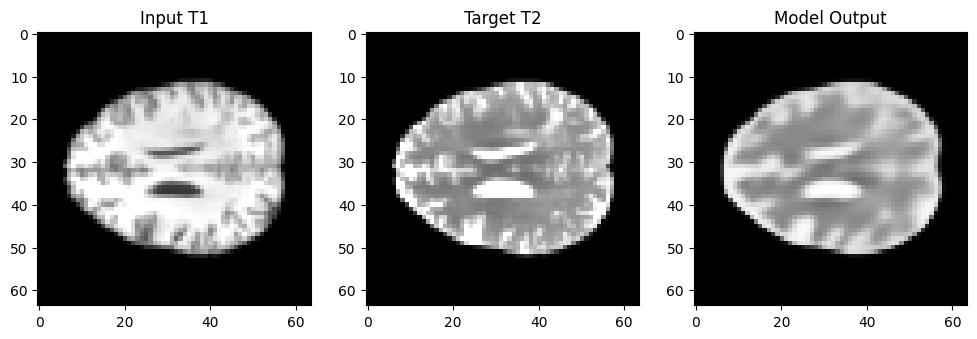

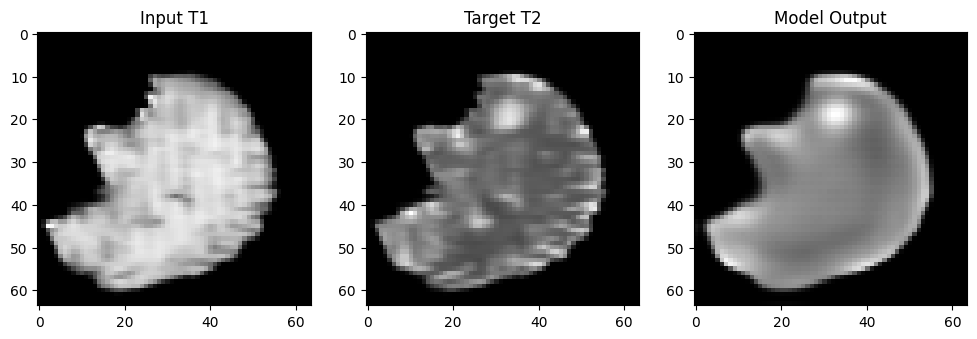

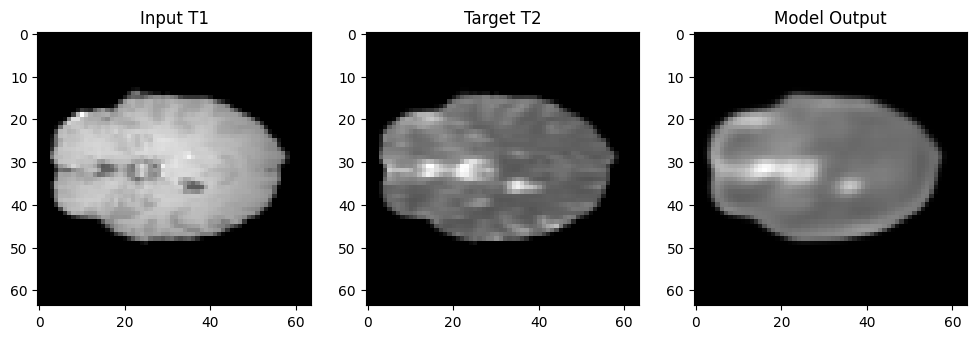

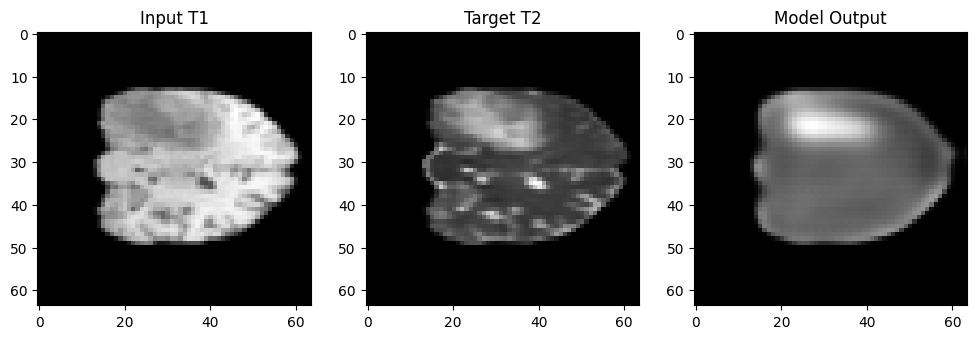

In [29]:
with torch.no_grad():
    pred = model(x)

for i in range(4):
  plt.figure(figsize=(12,4))
  plt.subplot(1,3,1); plt.imshow(x[i,0].cpu(), cmap='gray'); plt.title("Input T1")
  plt.subplot(1,3,2); plt.imshow(y[i,0].cpu(), cmap='gray'); plt.title("Target T2")
  plt.subplot(1,3,3); plt.imshow(pred[i,0].cpu(), cmap='gray'); plt.title("Model Output")
  plt.show()


In [30]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    for sample in train_loader:
        input, target = sample["t1"], sample["t2"]
        input, target = input.float().to(device), target.float().to(device)
        optimizer.zero_grad()

        recon = model(input)

        loss = criterion(recon, target)

        loss.backward()
        train_loss += loss.item() * batch_size
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    return avg_loss

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for sample in val_loader:
            input, target = sample["t1"], sample["t2"]
            input, target = input.to(device), target.to(device)
            recon = model(input)

            loss = criterion(recon, target)
            val_loss += loss.item() * batch_size

    avg_loss = val_loss / len(val_loader.dataset)
    return avg_loss

In [31]:
import wandb

run = wandb.init(
    project="DL_Assessment_Q1",
    # entity="francesco-remondi25",
    config={
        "learning_rate": lr,
        "architecture": "Dense-Unet",
        "batch_size": batch_size,
        "epochs": nepochs,
        "optimiser": "adam",
    }
)

!mkdir '/content/drive/My Drive/Q1_models'  # create the director for storing the model in Google Drive

model_save_name = 'Dense_UNet_model.pt'           # .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/drive/My Drive/models/{model_save_name}" # use this to store in your Google Drive storage

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: francesco-remondi25 (francesco-remondi25-imperial-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


mkdir: cannot create directory ‘/content/drive/My Drive/Q1_models’: File exists


In [ ]:
from IPython.display import clear_output

# Training loop
train_losses, valid_losses = [], []
for epoch in range(nepochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    valid_loss = validate(model, valid_loader, criterion, device)

    run.log({"train_loss": train_loss, "valid_loss": valid_loss})

    # Store losses
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    torch.save(model.state_dict(), path)

    # Clear and update plot
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(train_losses, label='Training Loss')
    ax.plot(valid_losses, label='Validation Loss')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    plt.show()

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

<br><br>

## 1.C) Discussion (max 250 words)

In this part you should provide a concise written discussion (maximum **250 words**) reflecting on your solution to Part 1.B. Your discussion should address the following points:

1. **Modelling choices and pre-processing**  
   Explain the main decisions behind your model architecture, loss function, and training strategy, and how they relate to the properties of the T1/T2 translation task.

2. **Performance and evaluation**  
   Interpret your **quantitative** results and **qualitative** reconstructions. Comment on how well your model appears to reconstruct `t2` features.

3. **Limitations and possible improvements**  
   Identify the main limitations of your current approach and outline concrete avenues for improvement. You may refer to alternative architectures, loss functions, or improved training and validation procedures.

Your answer should be technically focused, directly address these points, and remain within the stated word limit. Overly long or off-topic discussions will be penalised.


<br>

---

<br>

// Text answer

In the pre processing, some huge outliers in the distribution were found, hence the final decision was to normalise the data between 0 and 1, after winsorising between the 1st and 99th percentile. The winsorisation revealed to be necessary, as when only scaling between 0 and 1, most of the pixels were in the lower range, given the influence of the outliers, thus making the images more obscure in general.

Most part of the architecture has been inspired by the paper "Deep Learning Based Multi-Modal Fusion for Fast MR Reconstruction", which demonstrates the benefits of using a Dense over a "vanilla" UNet. Also the hyperparameters were mostly chosen after considering the ones from the same paper.

The input of the model are the T1 images, while the output are the T2 ones, sharing same shapes.

As a sanity check, one batch of size 4 was overfitted first in 1000 steps, to check if the architecture is working as expected, before training on the whole dataset. Reconstruction images for the overfitted batch were plotted to get an idea of how the model would be performing.

Given time costraints and model complexity, only the first 5 epochs have been trained for the full model, which might not be enough to get MSE converge. In the original paper, 100 epochs were run. Unfortunately, given the limited GPU units, and the fact that it xx minutes to run 5 epochs, on 7.5 units per hour, there was not enough room for a right amount of epochs and potential hyperparameter tuning.

<br>

---

<br>